In [ ]:
# --- 1. 기본 설정 및 라이브러리 임포트 ---

# 데이터 분석 및 처리를 위한 필수 라이브러리
import pandas as pd                                                     # 데이터 프레임 처리
import numpy as np                                                      # 수치 계산 및 배열 처리
import random                                                           # 난수 생성
import os, sys                                                          # 운영 체제 관련 기능 (파일 경로 등)
from datetime import datetime                                           # 날짜 및 시간 처리

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt                                         # 기본 시각화
import seaborn as sns                                                   # 고급 시각화
import shap                                                             # SHAP 값 계산 및 시각화
from scipy import stats                                                 # 통계적 계산 (예: 상관관계 분석)
from IPython.display import display                                     # Jupyter Notebook에서 객체 출력

# 모델링 및 기계 학습을 위한 라이브러리
import lightgbm as lgb                                                  # LightGBM 모델
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit    # 교차 검증을 위한 K-폴드 및 시계열 분할
from sklearn.preprocessing import LabelEncoder                          # 범주형 데이터 인코딩
from sklearn.metrics import mean_squared_error                          # 평가 지표 (RMSE 계산용)
from sklearn.cluster import KMeans                                      # K-평균 군집화
from sklearn.preprocessing import StandardScaler                        # 데이터 스케일링

# 하이퍼파라미터 최적화를 위한 라이브러리
import optuna                                                           # Optuna 라이브러리 (하이퍼파라미터 최적화)

# 기타 유틸리티
import json                                                             # 하이퍼파라미터 최적 파라미터를 JSON 파일로 저장  
import gc                                                               # 가비지 컬렉션 (메모리 관리)
from tqdm import tqdm                                                   # 작업 진행률 표시
import warnings                                                         # 경고 메시지 관리 
import joblib

# 로거(실행 기록 로그 저장) 임포트
src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
sys.path.insert(0, src_path)
from logger import Logger

# 한글 폰트 설정
import matplotlib.font_manager as fm
try:
    # 나눔고딕 폰트 경로 설정 (경로는 환경에 따라 조정 필요)
    font_path = '../../font/NanumFont/NanumGothic.ttf'
    
    # 폰트가 존재하는지 확인 후 설정
    if os.path.exists(font_path):
        fe = fm.FontEntry(fname=font_path, name='NanumGothic')
        fm.fontManager.ttflist.insert(0, fe)
        plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})
    else:
        print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
except Exception as e:
    print(f"폰트 설정 중 오류 발생: {e}")
    pass

# 불필요한 경고 메시지 무시
warnings.filterwarnings('ignore')

# 현재 시간 기준 년월일_시각 문자열 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 실행 로그 저장 경로 설정
LOG_DIR = '../../data/logs/price_prediction_loges/price_prediction_6_logs'                     # 실행 로그 디렉토리
LOG_FILENAME = f"price_prediction_{timestamp}.log"                      # 실행 로그 파일명
LOG_PATH = os.path.join(LOG_DIR, LOG_FILENAME)                          # 실행 로그 경로
os.makedirs(LOG_DIR, exist_ok=True)                                     # 실행 로그 디렉토리 생성
logger = Logger(log_path=LOG_PATH)                                      # 로거 인스턴스 생성

# 데이터 경로 설정
RAW_DIR             = '../../data/processed/cleaned_data'               # 원본 데이터 디렉토리
TRAIN_FILENAME      = 'train_xy.csv'                                    # 훈련 데이터 파일명
TEST_FILENAME       = 'test_xy.csv'                                     # 테스트 데이터 파일명
TRAIN_PATH          = os.path.join(RAW_DIR, TRAIN_FILENAME)             # 훈련 데이터 경로
TEST_PATH           = os.path.join(RAW_DIR, TEST_FILENAME)              # 테스트 데이터 경로
PARAMS_DIR          = '../../data/processed/params'                     # 최적 하이퍼파라미터 디렉토리
PARAMS_FILENAME     = 'best_params_6.json'                              # 최적 하이퍼파라미터 파일명
PARAMS_PATH         = os.path.join(PARAMS_DIR, PARAMS_FILENAME)         # 최적 하이퍼파라미터 경로
SUBMISSION_DIR      = '../../data/processed/submissions'                # 제출 파일 디렉토리
SUBMISSION_FILENAME = 'price_prediction_6_submission.csv'               # 제출 파일명
SUBMISSION_PATH     = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME) # 제출 파일 경로
MODEL_DIR           = '../../model'                                     # 모델 저장 디렉토리
MODEL_FILENAME      = 'price_prediction_6_model.pkl'                    # 모델 파일명
MODEL_PATH          = os.path.join(MODEL_DIR, MODEL_FILENAME)           # 모델 경로

# 결과 저장 디렉토리 생성
os.makedirs(PARAMS_DIR, exist_ok=True)
os.makedirs(SUBMISSION_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

logger.start_redirect()
logger.write("="*50)
logger.write(">> < 아파트 가격 예측 모델링 시작 >\n\n")
logger.write(">> [1단계 완료] 라이브러리, 경로, 로거 초기화 성공!")

In [47]:
# --- 2. 데이터 로드 및 초기 전처리 (수정 완료) ---
try:
    logger.write(">> [2단계 시작] 데이터 로드를 시작합니다...")
    
    # CSV 파일로부터 훈련 및 테스트 데이터를 로드합니다.
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)

    # 훈련 데이터와 테스트 데이터를 하나로 합칩니다.
    df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    logger.write(">> 데이터 로드 및 병합 완료.")
    
    # TimeSeriesSplit을 위해 '계약일자' 컬럼만으로 시간순 정렬합니다.
    df = df.sort_values(by=['계약일자']).reset_index(drop=True)
    logger.write(">> TimeSeriesSplit을 위해 데이터를 시간순으로 정렬했습니다.")
    logger.write(">> [2단계 완료] 데이터 로드 및 초기 전처리 성공.")
    
except Exception as e:
    logger.write(f">> [오류] 2단계 데이터 로드 및 전처리 중 문제 발생: {e}", print_error=True)

In [ ]:
# --- 3. 피처 엔지니어링 (Feature Engineering) ---
# 기존 데이터를 바탕으로 모델 성능을 높일 새로운 특성을 생성합니다.

try:
    logger.write(">> [3단계 시작] 피처 엔지니어링을 시작합니다...")
    
    # '계약년월'을 '계약년'과 '계약월'로 분리합니다.
    df['계약년'] = df['계약년월'].astype(str).str[:4].astype(int)
    df['계약월'] = df['계약년월'].astype(str).str[4:].astype(int)
    
    # 건물의 나이(연식)을 계산합니다.
    df['건물나이'] = df['계약년'] - df['연식']
    
    # 거래 시점(연도와 월의 조합)을 나타내는 특성을 생성합니다.
    df['거래시점'] = (df['계약년'] - 2007) * 12 + df['계약월']
    
    # --- K-평균 군집화 (K-Means Clustering) ---
    try:
        logger.write(">> K-평균 군집화를 시작합니다...")
        cluster_cols = ['좌표X', '좌표Y', '건물나이', '전용면적', '층']
        
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df[cluster_cols])
        
        kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
        df['아파트군집'] = kmeans.fit_predict(df_scaled)
        
        logger.write(f">> K-평균 군집화 완료. '{len(cluster_cols)}'개 특성을 사용해 10개의 '아파트군집' 생성.")

    except Exception as e:
        logger.write(f">> [오류] K-평균 군집화 중 문제 발생: {e}", print_error=True)
    
    # --- 고급 피처 엔지니어링 ---
    logger.write(">> 고급 피처 엔지니어링을 시작합니다...")

    # 중복 실행 방지를 위한 강력한 방어 코드
    # 병합하기 전에, 이전 실행으로 인해 생성되었을 수 있는 모든 통계 관련 컬럼을 제거합니다.
    # 접미사(_x, _y)가 붙은 중복 컬럼까지 모두 제거하여 오류를 원천적으로 방지합니다.
    stat_col_bases = [
        '동별_평균면적당가격', '동별_면적당가격편차',
        '구별_평균면적당가격', '구별_면적당가격편차'
    ]
    
    cols_to_drop = []
    for col_base in stat_col_bases:
        for df_col in df.columns:
            if df_col.startswith(col_base):
                cols_to_drop.append(df_col)
    
    if cols_to_drop:
        df = df.drop(columns=list(set(cols_to_drop)))
        logger.write(f">> 이전 실행에서 생성된 통계 피처 {len(set(cols_to_drop))}개를 제거했습니다.")

    # 계약월의 주기성을 나타내는 sin/cos 변환 피처 생성
    df['계약월_sin'] = np.sin(2 * np.pi * df['계약월']/12)
    df['계약월_cos'] = np.cos(2 * np.pi * df['계약월']/12)
    logger.write(">> 1. 시간 관련(sin/cos) 피처 생성 완료.")
    
    # 교통 편의성 가중합 특성
    df['가중지하철'] = df['반경_1km_지하철역_수'] * 1.0 + df['반경_500m_지하철역_수'] * 1.5 + df['반경_300m_지하철역_수'] * 2.0
    df['가중버스'] = df['반경_1km_버스정류장_수'] * 1.0 + df['반경_500m_버스정류장_수'] * 1.5 + df['반경_300m_버스정류장_수'] * 2.0
    logger.write(">> 2. 교통 관련 가중합 특성 생성 완료.")

    # 면적당 가격 기반 통계 피처 생성
    train_df_temp = df[df['target'].notna()].copy()
    train_df_temp['면적당가격'] = np.log1p(train_df_temp['target']) / train_df_temp['전용면적']

    # Named Aggregation을 사용하여 법정동 및 자치구별 통계 계산
    dong_price_stats = train_df_temp.groupby('법정동').agg(
        동별_평균면적당가격=('면적당가격', 'mean'),
        동별_면적당가격편차=('면적당가격', 'std')
    ).reset_index()
    
    gu_price_stats = train_df_temp.groupby('자치구').agg(
        구별_평균면적당가격=('면적당가격', 'mean'),
        구별_면적당가격편차=('면적당가격', 'std')
    ).reset_index()
    
    # 전체 데이터프레임에 통계 피처 병합
    df = pd.merge(df, dong_price_stats, on='법정동', how='left')
    df = pd.merge(df, gu_price_stats, on='자치구', how='left')
    logger.write(">> 3. 면적당 가격 관련 통계 피처 생성 및 병합 완료.")

    # 상호작용 특성 생성
    df['면적_x_나이'] = df['전용면적'] * df['건물나이']
    df['면적_x_층'] = df['전용면적'] * df['층']
    df['강남_x_면적'] = df['강남3구여부'] * df['전용면적']
    logger.write(">> 4. 상호작용 특성 생성 완료.")

    # 생성된 통계 피처의 결측치 처리
    fill_na_cols = ['동별_평균면적당가격', '동별_면적당가격편차', '구별_평균면적당가격', '구별_면적당가격편차']
    existing_cols = [col for col in fill_na_cols if col in df.columns]
    
    if existing_cols:
        train_rows_mask = df['target'].notna()
        mean_vals = df.loc[train_rows_mask, existing_cols].mean()
        df[existing_cols] = df[existing_cols].fillna(mean_vals)
        logger.write(">> 5. 통계 피처 결측치 처리 완료.")

    logger.write(">> 고급 피처 엔지니어링 완료.")
    logger.write(">> [3단계 완료] 피처 엔지니어링 성공.")
    
except Exception as e:
    logger.write(f">> [오류] 3단계 피처 엔지니어링 중 문제 발생: {e}", print_error=True)

In [49]:
# --- 4. 최종 데이터 준비 및 인코딩 ---

try:
    logger.write(">> [4단계 시작] 최종 데이터 준비 및 인코딩을 시작합니다...")
    
    # 1. 타겟 변수 로그 변환 (학습 데이터에만 적용)
    train_rows_mask = df['target'].notna()
    df.loc[train_rows_mask, 'target'] = np.log1p(df.loc[train_rows_mask, 'target'])
    logger.write(">> 타겟 변수(target) 로그 변환 완료.")
    
    # 2. 범주형 데이터 라벨 인코딩
    categorical_features = df.select_dtypes(include=['object']).columns
    for col in categorical_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    logger.write(">> 범주형 데이터 라벨 인코딩 완료.")
    
    # 3. 훈련 / 테스트 데이터 최종 분리
    train_df = df[df['target'].notna()]
    test_df = df[df['target'].isna()]
    test_df = test_df.drop('target', axis=1)

    logger.write(f">> 최종 데이터 분리 완료. 훈련 데이터: {train_df.shape}, 테스트 데이터: {test_df.shape}")
    logger.write(">> [4단계 완료] 최종 데이터 준비 및 인코딩 성공.")
    
except Exception as e:
    logger.write(f">> [오류] 4단계 최종 데이터 준비 중 문제 발생: {e}", print_error=True)

In [50]:
# --- 5. 특성 선택 (Feature Selection) (수정 완료) ---
# LightGBM 모델을 한 번 실행하여 모델 성능에 중요하게 기여하는 특성들을 선별합니다.

try:
    logger.write(">> [5단계 시작] 특성 선택 및 빠른 최적화를 위한 데이터 분리를 시작합니다...")
    
    # 1. 모델의 입력(X)과 정답(y) 정의
    features_to_drop_train = ['target', '계약년월', '계약일자']
    X_train = train_df.drop(columns=features_to_drop_train)
    y_train = train_df['target']
    
    features_to_drop_test = ['계약년월', '계약일자']
    X_test = test_df.drop(columns=features_to_drop_test)
    
    common_cols = list(X_train.columns)
    X_test = X_test[common_cols]
    
    # 2. LightGBM으로 중요 특성 선별
    temp_model = lgb.LGBMRegressor(random_state=42)
    temp_model.fit(X_train, y_train)
    
    feature_importances = pd.Series(temp_model.feature_importances_, index=X_train.columns)
    selected_features = feature_importances[feature_importances > 0].index.tolist()
    
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    logger.write(f">> 특성 선택 완료. 총 {len(X_train.columns)}개 중 {len(selected_features)}개 선택됨.")
    
    # 3. [핵심] 빠른 Optuna 최적화를 위해 훈련/검증 데이터 한 번만 분리
    # TimeSeriesSplit의 마지막 Fold와 유사하게 데이터를 분리합니다 (예: 마지막 20%를 검증용으로 사용)
    split_index = int(len(X_train_selected) * 0.8)
    X_train_opt = X_train_selected[:split_index]
    y_train_opt = y_train[:split_index]
    X_val_opt = X_train_selected[split_index:]
    y_val_opt = y_train[split_index:]
    
    logger.write(f">> 빠른 최적화를 위한 데이터 분리 완료. Train: {len(X_train_opt)}, Validation: {len(X_val_opt)}")
    logger.write(">> [5단계 완료] 특성 선택 및 데이터 분리 성공.")
    
except Exception as e:
    logger.write(f">> [오류] 5단계 특성 선택 및 데이터 분리 중 문제 발생: {e}", print_error=True)

In [51]:
# --- 6. 하이퍼파라미터 최적화 (Optuna) ---
# 모델의 성능을 극대화하기 위해 최적의 하이퍼파라미터 조합을 탐색합니다.

try:
    # 단일 검증 세트를 사용하는 빠른 objective 함수
    def objective_fast(trial, X_train, y_train, X_val, y_val):
        param = {
            'objective': 'regression_l1', 'metric': 'rmse',
            'n_estimators': 1000, # n_estimators를 약간 줄여 속도 향상
            'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42,
            'device': 'cuda', 'n_jobs': -1,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
            'num_leaves': trial.suggest_int('num_leaves', 30, 150),
            'max_depth': trial.suggest_int('max_depth', 7, 25),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True),
        }

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        
        val_preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        return rmse

    # Optuna 최적화 실행
    if 'X_train_selected' in locals():
        logger.write(">> [6단계 시작] Optuna로 하이퍼파라미터 최적화(빠른 버전)를 시작합니다...")
        
        study = optuna.create_study(direction='minimize')
        # 분리된 데이터를 objective 함수에 전달
        study.optimize(lambda trial: objective_fast(trial, X_train_opt, y_train_opt, X_val_opt, y_val_opt), n_trials=30) # n_trials도 약간 줄여서 시간 단축
        
        best_params = study.best_params
        best_params.update({
            'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000, # 최종 모델은 n_estimators 늘려서 학습
            'verbosity': -1, 'seed': 42, 'device': 'cuda'
        })
        
        logger.write(f">> Optuna 탐색 완료. 최적 파라미터: {best_params}")
        logger.write(">> [6단계 완료] 하이퍼파라미터 최적화 성공.")

except Exception as e:
    logger.write(f">> [오류] 6단계 하이퍼파라미터 최적화 중 문제 발생: {e}", print_error=True)


In [59]:
# --- 7. 최종 모델 훈련, 저장 및 예측 ---
# Optuna로 찾은 최적 파라미터로 최종 모델을 훈련하고, 파일로 저장한 뒤 예측을 수행합니다.
import joblib

try:
    if 'best_params' in locals():
        logger.write(">> [7단계 시작] 최종 모델 훈련, 저장 및 예측을 시작합니다...")
        
        # 1. 최종 LightGBM 모델을 최적의 파라미터로 초기화합니다.
        final_model = lgb.LGBMRegressor(**best_params)
        
        # 2. 선택된 특성으로 구성된 전체 훈련 데이터를 사용하여 모델을 훈련합니다.
        logger.write(">> 최종 모델 훈련을 시작합니다...")
        final_model.fit(X_train_selected, y_train)
        logger.write(">> 최종 모델 훈련 완료.")
        
        # 3. [핵심] 훈련된 모델을 파일로 저장합니다.
        joblib.dump(final_model, MODEL_PATH)
        logger.write(f">> 모델 저장 완료: {MODEL_PATH}")
        
        # 4. 테스트 데이터에 대한 예측을 수행합니다.
        predictions = final_model.predict(X_test_selected)
        
        # 5. 변환되었던 예측값을 원래의 가격 스케일로 되돌립니다.
        predictions = np.expm1(predictions)
        
        # 6. 'target' 컬럼만 포함된 제출 파일을 생성
        submission_df = pd.DataFrame({'target': predictions.astype(int)})
        submission_df.to_csv(SUBMISSION_PATH, index=False)
        logger.write(f">> 'target' 값만 포함된 제출 파일 생성 완료: {SUBMISSION_PATH}")

        logger.write(">> [7단계 완료] 최종 모델 훈련, 저장 및 예측 성공.")
    else:
        logger.write(">> [알림] 6단계 하이퍼파라미터 최적화가 실행되지 않아 7단계를 건너뜁니다.")
        
except Exception as e:
    logger.write(f">> [오류] 7단계 최종 모델 훈련, 저장 및 예측 중 문제 발생: {e}", print_error=True)

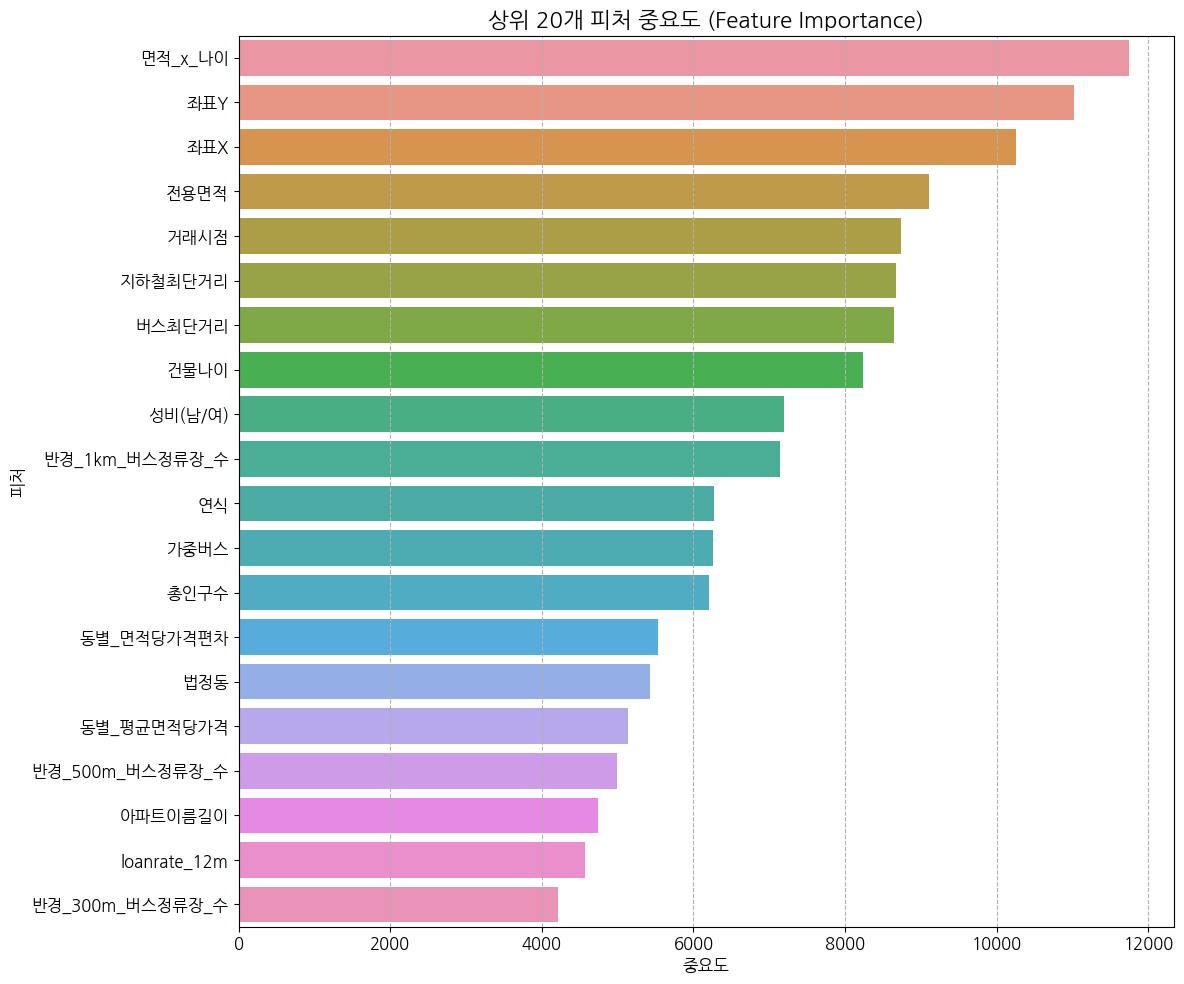

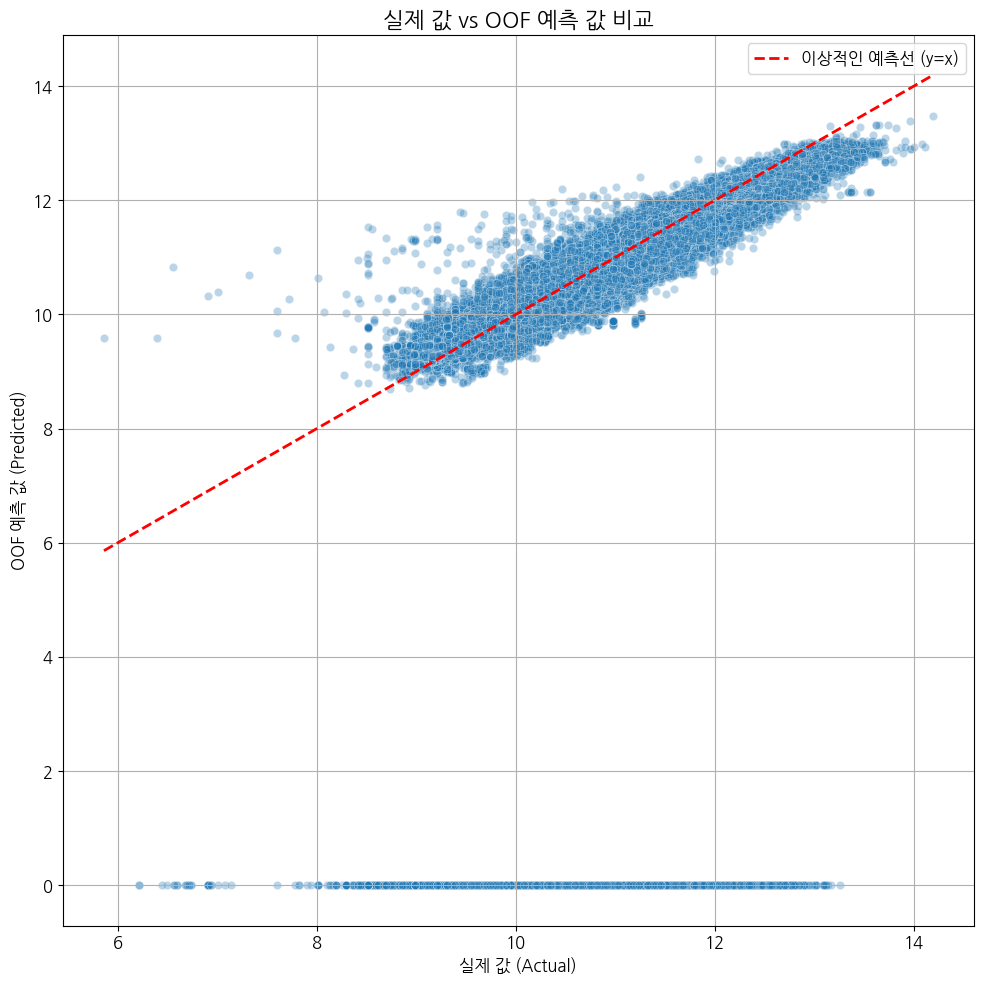

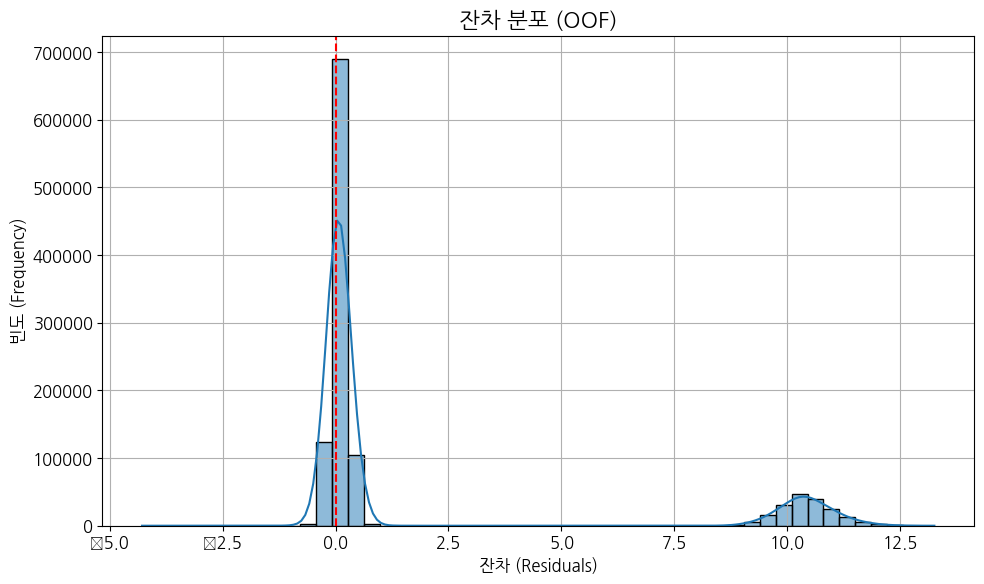

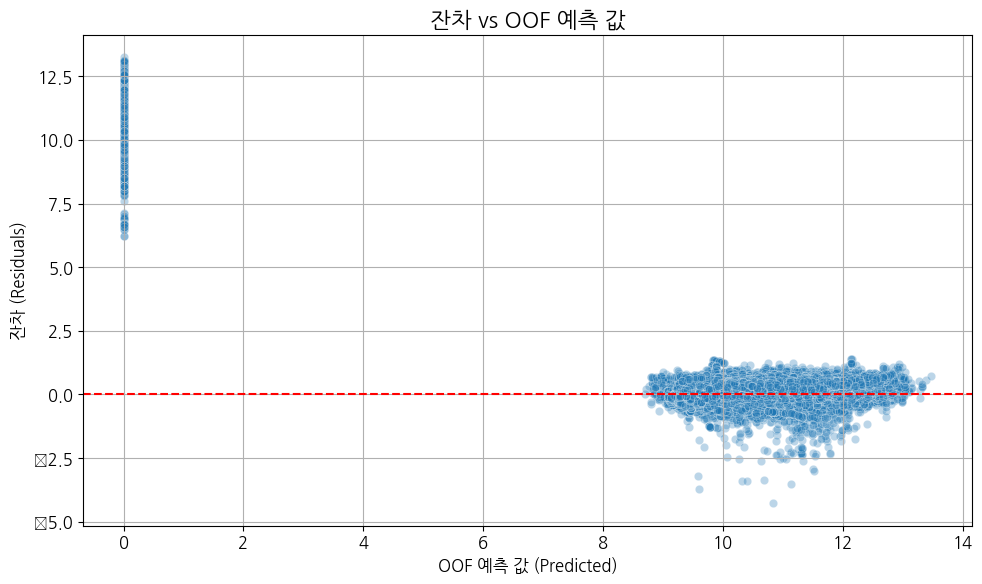

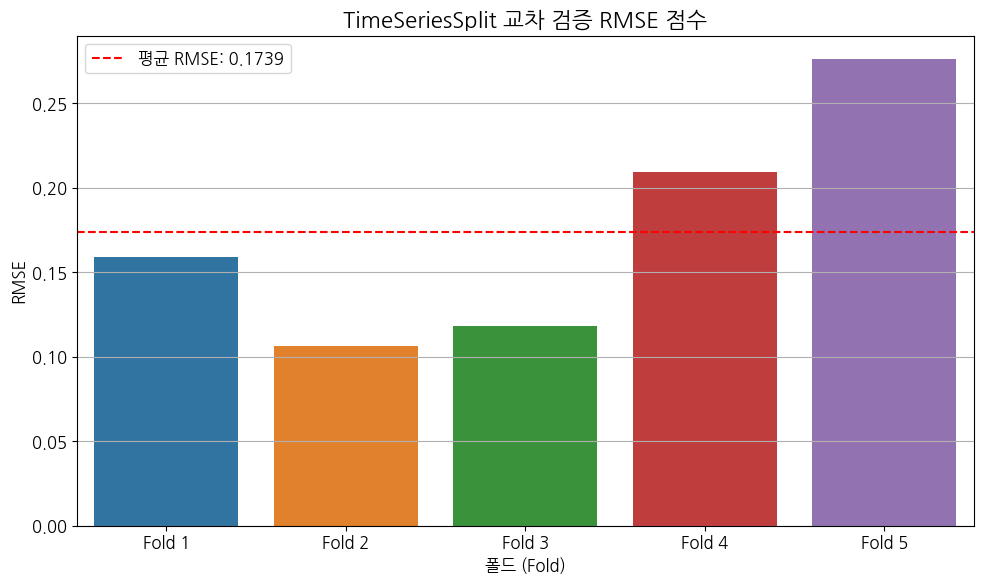

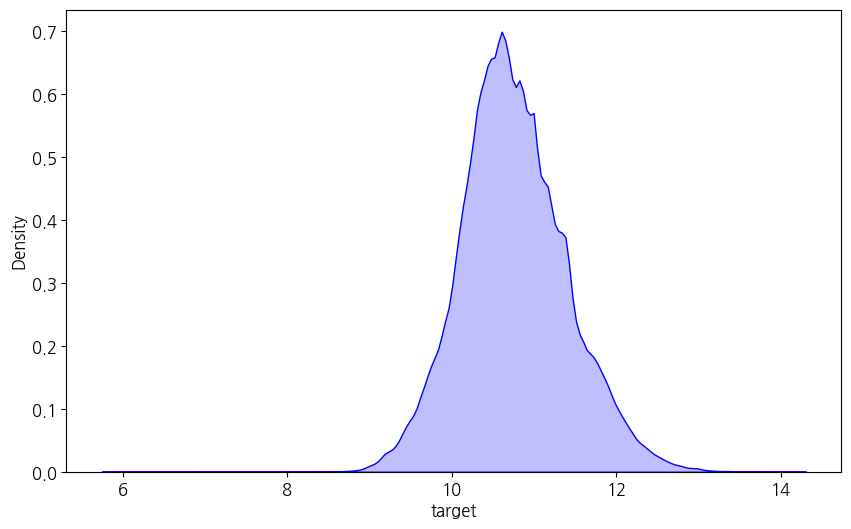

In [ ]:
# --- 8. 최종 모델 검증 및 시각화 ---
# 모델의 성능을 다각도로 분석하고, 예측의 근거를 확인합니다.

try:
    if 'final_model' in locals():
        logger.write(">> [8단계 시작] 최종 모델 검증 및 시각화를 시작합니다...")

        # --- 1. OOF 예측 생성 및 CV 점수 확보 (신뢰도 높은 분석을 위함) ---
        logger.write(">> 1. OOF(Out-of-Fold) 예측값 및 CV 점수를 생성합니다...")
        
        # TimeSeriesSplit 설정
        tscv = TimeSeriesSplit(n_splits=1)
        
        oof_preds = np.zeros(X_train_selected.shape[0]) # OOF 예측을 저장할 배열
        cv_rmse_scores = [] # 각 Fold의 RMSE 점수를 저장할 리스트

        # 교차 검증을 다시 수행하여 OOF 예측 생성
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_selected)):
            X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # best_params로 모델을 다시 훈련
            model = lgb.LGBMRegressor(**best_params)
            model.fit(X_train_fold, y_train_fold,
                      eval_set=[(X_val_fold, y_val_fold)],
                      eval_metric='rmse',
                      callbacks=[lgb.early_stopping(50, verbose=False)])
            
            # 검증 세트(Validation Set)에 대한 예측값을 OOF 배열의 해당 위치에 저장
            val_preds = model.predict(X_val_fold)
            oof_preds[val_idx] = val_preds
            
            # 현재 Fold의 RMSE 점수 계산 및 저장
            rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
            cv_rmse_scores.append(rmse)
            logger.write(f">> Fold {fold+1} RMSE: {rmse:.4f}")

        logger.write(f">> 최종 CV 평균 RMSE: {np.mean(cv_rmse_scores):.4f}")
        
        # --- 2. 피처 중요도(Feature Importance) 시각화 ---
        logger.write("\n>> 2. 피처 중요도를 시각화합니다...")
        feature_importances = pd.DataFrame(
            {'feature': X_train_selected.columns, 'importance': final_model.feature_importances_}
        ).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
        plt.title('상위 20개 피처 중요도 (Feature Importance)', fontsize=16)
        plt.xlabel('중요도', fontsize=12)
        plt.ylabel('피처', fontsize=12)
        plt.grid(True, axis='x', linestyle='--')
        plt.tight_layout()
        plt.show()

        # --- 3. 실제 값 vs OOF 예측 값 비교 (Scatter Plot) ---
        logger.write("\n>> 3. 실제 값과 OOF 예측 값을 비교합니다...")
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=y_train, y=oof_preds, alpha=0.3)
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='이상적인 예측선 (y=x)')
        plt.title('실제 값 vs OOF 예측 값 비교', fontsize=16)
        plt.xlabel('실제 값 (Actual)', fontsize=12)
        plt.ylabel('OOF 예측 값 (Predicted)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- 4. 잔차(Residuals) 분석 ---
        logger.write("\n>> 4. 잔차(실제-예측)를 분석합니다...")
        residuals = y_train - oof_preds
        
        # 잔차 분포 (Histogram)
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, bins=50)
        plt.title('잔차 분포 (OOF)', fontsize=16)
        plt.xlabel('잔차 (Residuals)', fontsize=12)
        plt.ylabel('빈도 (Frequency)', fontsize=12)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 잔차 vs 예측 값 (Scatter Plot)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=oof_preds, y=residuals, alpha=0.3)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('잔차 vs OOF 예측 값', fontsize=16)
        plt.xlabel('OOF 예측 값 (Predicted)', fontsize=12)
        plt.ylabel('잔차 (Residuals)', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- 5. 교차 검증(CV) 폴드별 RMSE 점수 시각화 ---
        logger.write("\n>> 5. 교차 검증 폴드별 RMSE 점수를 시각화합니다...")
        plt.figure(figsize=(10, 6))
        sns.barplot(x=[f'Fold {i+1}' for i in range(len(cv_rmse_scores))], y=cv_rmse_scores)
        plt.title('TimeSeriesSplit 교차 검증 RMSE 점수', fontsize=16)
        plt.xlabel('폴드 (Fold)', fontsize=12)
        plt.ylabel('RMSE', fontsize=12)
        plt.axhline(y=np.mean(cv_rmse_scores), color='r', linestyle='--', label=f'평균 RMSE: {np.mean(cv_rmse_scores):.4f}')
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        # --- 6. 학습 데이터와 테스트 예측 결과 분포 비교 (KDE Plot) ---
        logger.write("\n>> 6. 학습 데이터와 테스트 예측의 분포를 비교합니다...")
        plt.figure(figsize=(10, 6))
        # 로그 변환된 값으로 비교해야 스케일이 맞음
        sns.kdeplot(y_train, label='학습 데이터 실제 값 (Log)', color='blue', fill=True)
        sns.kdeplot(np.log1p(predictions), label='테스트 데이터 예측 값 (Log)', color='orange', fill=True)
        plt.title('학습 데이터와 테스트 예측의 분포 비교 (Log Scale)', fontsize=16)
        plt.xlabel('아파트 가격 (Log Transformed)', fontsize=12)
        plt.ylabel('밀도 (Density)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- 7. SHAP (SHapley Additive exPlanations) 분석 ---
        logger.write("\n>> 7. SHAP 분석을 시작합니다 (계산에 시간이 다소 소요될 수 있습니다)...")
        try:
            explainer = shap.TreeExplainer(final_model)
            # 데이터가 너무 크면 샘플링하여 사용 (1000개 샘플)
            shap_sample = X_train_selected.sample(1000, random_state=42)
            shap_values = explainer.shap_values(shap_sample)

            # SHAP 요약 플롯 (Summary Plot)
            logger.write(">> SHAP 요약 플롯: 각 피처가 예측에 미치는 영향을 종합적으로 보여줍니다.")
            shap.summary_plot(shap_values, shap_sample, plot_type="dot")

            # SHAP 의존성 플롯 (Dependence Plot)
            logger.write("\n>> SHAP 의존성 플롯: '전용면적'이 예측 가격에 미치는 영향을 보여줍니다.")
            shap.dependence_plot('전용면적', shap_values, shap_sample, interaction_index="건물나이")

        except Exception as e:
            logger.write(f">> [오류] SHAP 분석 중 문제가 발생했습니다: {e}", print_error=True)

        logger.write("\n>> [8단계 완료] 모델 분석 및 시각화 성공.")

    else:
        logger.write(">> [알림] 최종 모델이 생성되지 않아 8단계 시각화를 건너뜁니다.")

except Exception as e:
    logger.write(f">> [오류] 8단계 모델 분석 및 시각화 중 문제 발생: {e}", print_error=True)
    
# finally:
#         logger.stop_redirect()
#         logger.write(">> 모델링 종료")
#         logger.write("="*50 + "\n")
#         logger.close()